# pH-rate Profile for Esters

**NOTE: This version of the workbook has code for more formal plots.**

In water esters have three possible routes to hydrolysis. 

1. Water attacks the carbonyl group of the ester.
2. Acid catalysis: Water attacks the protonated carbonyl group of the ester.
3. Base catalysis: Hydroxide attacks the carbonyl group of the ester

Let us explore analyzing data for ester hydrolysios

This workbook contains the code and imports the data from multiple files and fits the data to the model..

The data being plotted is from "The Hydrolysis of Diclofenac Esters: Synthetic Prodrug Building Blocks for Biodegradable Drug–Polymer Conjugates." Feng Wang, Joshua Finnin et al., *J. Pharm. Sci.*, **2016**, *105*, 773-785.  https://doi.org/10.1002/jps.24665

The data is found in tables within the supplementary material at https://ars.els-cdn.com/content/image/1-s2.0-S0022354915001550-mmc1.docx


## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [1]:
### SETUP

!pip install uncertainties
!pip install lmfit
!mkdir plots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import curve_fit

import uncertainties as un
from uncertainties import unumpy as unp

import lmfit

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_19/data/"
github_location = "data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"



mkdir: plots: File exists


## Read Data

Read the data in from the csv text file.

In [2]:
### READ DATA
# datafiles are "3ab.csv" and "3c.csv"

data_file = "3ab.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

print(df)

      pH  k1 (10-5 hr-1)  t1/2 (hr)     r^2
0   1.00         4270.00       16.3  0.9895
1   1.54         1010.00       68.6  0.9988
2   1.90          352.00      197.0  0.9864
3   2.80          102.00      679.0  0.9989
4   3.22           38.40     1810.0  0.9973
5   3.52           18.90     3680.0  0.9976
6   4.02            8.46     8190.0  0.9857
7   4.45            2.46    28200.0  0.8401
8   4.87            3.02    23000.0  0.8858
9   5.34           13.30     5230.0  0.9906
10  5.97           49.10     1410.0  0.9995
11  6.59          182.00      382.0  0.9998
12  6.93          412.00      168.0  0.9999
13  7.32         1050.00       66.2  0.9997
14  7.82         2880.00       24.1  0.9999


## Plot Data

This code will quickly plot the data. We idenify the columns we want to use for $x$ and $y$ and then call the plot function.

kHKa = 0.49+/-0.05
kOH = (4.7+/-0.5)e+04


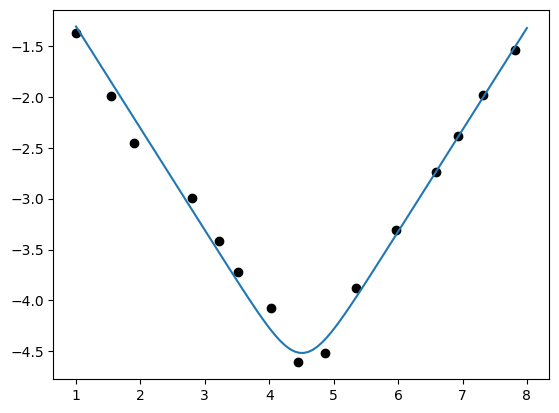

In [3]:
plt.rcdefaults()

x = df["pH"]
y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)

plt.plot(x,y, "ko")

def line1(x, int):
    ### slope set to -1. We are fitting only for the intercept.
    y = x * -1 + int
    return y

def line2(x, int):
    ### slope set to +1. We are fitting only for the intercept.
    y = x * 1 + int
    return y

def model2(pH, kHKa, kOH):
    H = 10**(-pH)
    Kw = 10**-13.995
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2
    return np.log10(kobs)
     
def model3(pH, kHKa, kH2O, kOH):
    H = 10**(-pH)
    Kw = 10**-13.995
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

popt,pcov = curve_fit(model2, x, y,
                      p0 = (1,100),
                      bounds=([0,0],[np.inf,np.inf])
                      )

kHKa, kOH = un.correlated_values(popt,pcov)
print(f"kHKa = {kHKa}")
print(f"kOH = {kOH}")


x1 = np.linspace(1,8,100)
y1 = model2(x1, *popt)

plt.plot(x1, y1)


In [9]:
data_file = "3c.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

 ### Use curve_fit function  

# define the function for the model
def profile3(pH, kHKa, kH2O, kOH):
    H = 10**(-pH)
    Kw = 10**-13.995
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(profile3)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa = dict(value = 1, min=0), 
                       kH2O = dict(value = 1, min=0), 
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.ci_report())


         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 kHKa:  -0.11971  -0.07142  -0.03399   0.20443  +0.03944  +0.10063  +0.23339
 kH2O:  -0.00060  -0.00035  -0.00016   0.00111  +0.00018  +0.00046  +0.00102
 kOH :-393534.99058-224086.49260-103500.403311024894.11767+114348.61113+282028.03149+615902.00546


In [11]:
data_file = "3ab.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 


### Use curve_fit function  

# define the function for the model
def profile2(pH, kHKa, kOH):
    H = 10**(-pH)
    Kw = 10**-13.995
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(profile2)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa = dict(value = 1, min=0), 
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.ci_report())


         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 kHKa:  -0.16403  -0.10578  -0.05281   0.49009  +0.05890  +0.13341  +0.24168
 kOH :-15894.01978-10267.50592-5133.5208346783.11417+5741.47339+13026.70905+23651.14475


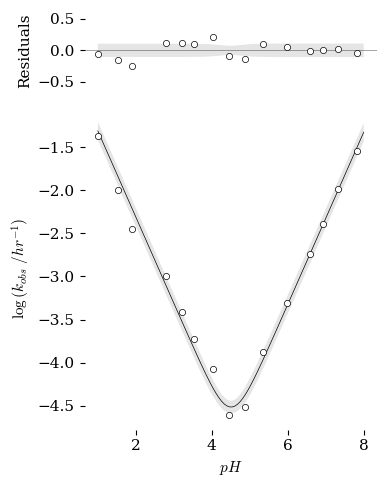

[[Model]]
    Model(profile2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 15
    # variables        = 2
    chi-square         = 0.20984310
    reduced chi-square = 0.01614178
    Akaike info crit   = -60.0416807
    Bayesian info crit = -58.6255803
    R-squared          = 0.98618859
[[Variables]]
    kHKa:  0.49008574 +/- 0.05380652 (10.98%) (init = 1)
    kOH:   46783.1142 +/- 5238.39283 (11.20%) (init = 1)


In [12]:
###############################################################################
### FANCY PLOT OF RESULT
###############################################################################

x1 = np.linspace(1,8,100)
y1 = result.eval(pH = x1)
dely = result.eval_uncertainty(pH = x1, sigma=2)   # 95% confidence band


size2 = 4,5
###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          title = Title,       
          ylabel=r"$\log{(k_{obs}\ /hr^{-1})}$",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
#          xticks = [1,3,5,7],
#          yticks = [0,-1,-2,-3],
       )

### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1].plot(x1,unp.nominal_values(y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)

# Confidence band
fit_up = y1 + dely
fit_dn = y1 - dely
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual     

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
# make filled band
ax[0].fill_between(x1, dely, -dely, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])

################################################
### Output Plot
################################################

name = "plot13"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax[0].patch.set_facecolor([0, 0, 0, 0])  
ax[1].patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()
print(result.fit_report())


         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 kHKa:  -0.11971  -0.07142  -0.03399   0.20443  +0.03944  +0.10063  +0.23339
 kH2O:  -0.00060  -0.00035  -0.00016   0.00111  +0.00018  +0.00046  +0.00102
 kOH :-165952.32954-94496.49043-43645.75821432194.26584+48220.40945+118930.23472+259723.72213
[[Model]]
    Model(profile3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 9
    # variables        = 3
    chi-square         = 0.04226078
    reduced chi-square = 0.00704346
    Akaike info crit   = -42.2500836
    Bayesian info crit = -41.6584099
    R-squared          = 0.99524758
[[Variables]]
    kHKa:  0.20442919 +/- 0.03429308 (16.78%) (init = 1)
    kH2O:  0.00110699 +/- 1.6074e-04 (14.52%) (init = 1)
    kOH:   432194.266 +/- 42057.2829 (9.73%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kHKa, kH2O) = -0.2353
    C(kH2O, kOH)  = -0.1581
         99.73%    95.45%    68.27%

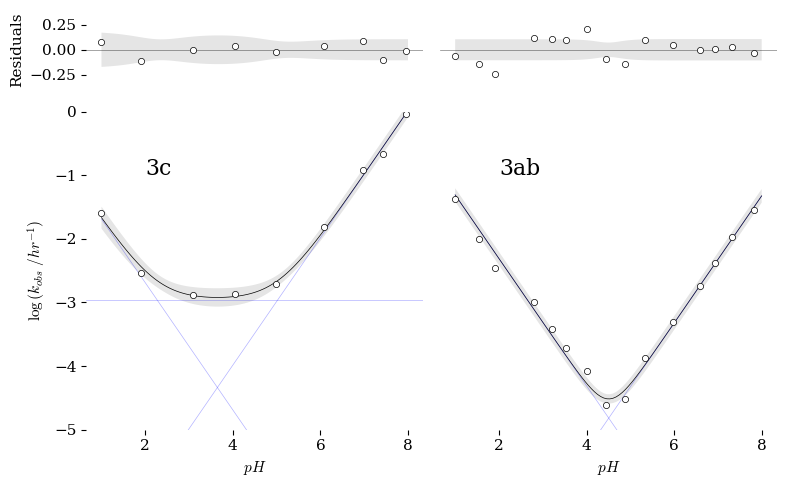

[[Model]]
    Model(profile2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 15
    # variables        = 2
    chi-square         = 0.20984310
    reduced chi-square = 0.01614178
    Akaike info crit   = -60.0416807
    Bayesian info crit = -58.6255803
    R-squared          = 0.98618859
[[Variables]]
    kHKa:  0.49008572 +/- 0.05380666 (10.98%) (init = 1)
    kOH:   19728.2767 +/- 2209.00489 (11.20%) (init = 1)


In [61]:
data_file = "3c.csv"
Kw = 10**-14    # at 37 degrees
Kw = 10**-13.62    # at 37 degrees

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

 ### Use curve_fit function  

# define the function for the model
def profile3(pH, kHKa, kH2O, kOH):
    H = 10**(-pH)
#    Kw = 10**-14    # at 37 degrees
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(profile3)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa = dict(value = 1, min=0), 
                       kH2O = dict(value = 1, min=0), 
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.ci_report())


###########
###########

###############################################################################
### FANCY PLOT OF RESULT
###############################################################################

x1 = np.linspace(1,8,100)
y1 = result.eval(pH = x1)
dely = result.eval_uncertainty(pH = x1, sigma=2)   # 95% confidence band
kHKa = result.best_values["kHKa"]
kH2O = result.best_values["kH2O"]
kOH = result.best_values["kOH"]

y_kHKa = np.log10(kHKa * 10**-x1)
y_kH2O = np.log10(kH2O)
y_kOH = np.log10(kOH*Kw / 10**-x1)

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,5), height_ratios=[1, 4])  

# Settings for plot
ax[1][0].set(
#          title = Title,       
          ylabel=r"$\log{(k_{obs}\ /hr^{-1})}$",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-5,0]
#          xticks = [1,3,5,7],
#          yticks = [0,-1,-2,-3],
       )

### Data graphics
ax[1][0].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1][0].plot(x1,unp.nominal_values(y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)

# Confidence band
fit_up = y1 + dely
fit_dn = y1 - dely
ax[1][0].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

ax[1][0].text(2,-1,"3c", fontsize = "x-large")

ax[1][0].plot(x1, y_kHKa, 
           marker = None, color = "blue", alpha = 0.3,
           linewidth=0.5, zorder = 0)
ax[1][0].plot(x1, y_kOH, 
           marker = None, color = "blue", alpha = 0.3, 
           linewidth=0.5, zorder = 0)
ax[1][0].axhline(y=y_kH2O, color = "blue", alpha = 0.3, linewidth=0.5, zorder = 0)

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual     

ax[0][0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-0.4,0.4]
       )
### Data graphics
ax[0][0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
# make filled band
ax[0][0].fill_between(x1, dely, -dely, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0][0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0][0].set_xticks([])

print(result.fit_report())

#########
#########

data_file = "3ab.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 


### Use curve_fit function  

# define the function for the model
def profile2(pH, kHKa, kOH):
    H = 10**(-pH)
#    Kw = 10**-14    # at 37 degrees
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(profile2)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa = dict(value = 1, min=0), 
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.ci_report())


###############
###############


###############################################################################
### FANCY PLOT OF RESULT
###############################################################################

x1 = np.linspace(1,8,100)
y1 = result.eval(pH = x1)
dely = result.eval_uncertainty(pH = x1, sigma=2)   # 95% confidence band

kHKa = result.best_values["kHKa"]
kOH = result.best_values["kOH"]

y_kHKa = np.log10(kHKa * 10**-x1)
y_kOH = np.log10(kOH*Kw / 10**-x1)


size2 = 4,5
###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################


# Settings for plot
ax[1][1].set(
#          title = Title,       
          ylabel=r"",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-5,0],
#          xticks = [1,3,5,7],
          yticks = [],
       )

### Data graphics
ax[1][1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1][1].plot(x1,unp.nominal_values(y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)

# Confidence band
fit_up = y1 + dely
fit_dn = y1 - dely
ax[1][1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

ax[1][1].plot(x1, y_kHKa, 
           marker = None, color = "blue", alpha = 0.3,
           linewidth=0.5, zorder = 0)
ax[1][1].plot(x1, y_kOH, 
           marker = None, color = "blue", alpha = 0.3, 
           linewidth=0.5, zorder = 0)

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual     

ax[0][1].set(
#          title = Title,       
          ylabel=r"", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-0.4,0.4],
          yticks = []
       )
### Data graphics
ax[0][1].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
# make filled band
ax[0][1].fill_between(x1, dely, -dely, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0][1].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0][1].set_xticks([])

ax[1][1].text(2,-1,"3ab", fontsize = "x-large")

################################################
### Output Plot
################################################

name = "plot14"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax[0][0].patch.set_facecolor([0, 0, 0, 0])  
ax[1][0].patch.set_facecolor([0, 0, 0, 0])  
ax[0][1].patch.set_facecolor([0, 0, 0, 0])  
ax[1][1].patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()
print(result.fit_report())
